In [1]:
from codecarbon import EmissionsTracker
import logging
output_directory = "/fp/homes01/u01/ec-krimhau/thesis_code/"

tracker = EmissionsTracker(output_dir=output_directory)
tracker.start()

[codecarbon INFO @ 10:40:27] [setup] RAM Tracking...
[codecarbon INFO @ 10:40:27] [setup] GPU Tracking...
[codecarbon INFO @ 10:40:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:40:27] [setup] CPU Tracking...
[codecarbon WARNING @ 10:40:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 10:40:30] We saw that you have a AMD EPYC 7642 48-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 10:40:30] CPU Model on constant consumption mode: AMD EPYC 7642 48-Core Processor
[codecarbon INFO @ 10:40:30] >>> Tracker's metadata:
[codecarbon INFO @ 10:40:30]   Platform system: Linux-5.14.0-362.8.1.el9_3.x86_64-x86_64-with-glibc2.34
[codecarbon INFO @ 10:40:30]   Python version: 3.11.3
[codecarbon INFO @ 10:40:30]   CodeCarbon version: 2.3.4
[codecarbon INFO @ 10:40:30]   Available RAM : 256.000 GB
[codecarbon INFO @ 10:40:30]   CPU count: 24
[codecarbon INFO @ 10:40:30]   CPU model: AMD EPYC 7642 48-Core Processor
[codecarbon 

In [2]:
logging.getLogger('codecarbon').setLevel(logging.WARNING)

In [3]:
import os
import gc
import copy
import time
import random
import string
import joblib

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold, KFold

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AutoConfig, AdamW
from transformers import DataCollatorWithPadding
import datasets
# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

import wandb
# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
# Load .env file
%load_ext dotenv
%dotenv /fp/homes01/u01/ec-krimhau/thesis_code/.env

In [5]:
# Get wandb api key from .env file
wandb_api_key = os.getenv('WANDB_API_KEY')
# Login to wandb to track results
wandb.login(key = wandb_api_key) # API key

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: haugerud-kristian (krimhau). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /fp/homes01/u01/ec-krimhau/.netrc


True

In [6]:
def id_generator(size=12, chars=string.ascii_lowercase + string.digits):
    return ''.join(random.SystemRandom().choice(chars) for _ in range(size))


HASH_NAME = id_generator(size=12)
print(HASH_NAME)


n5wig1w3dihu


In [7]:
CONFIG = {"seed": 42,
          "epochs": 3,
          "model_name": "microsoft/deberta-v3-base",
          "train_batch_size": 8,
          "valid_batch_size": 16,
          "max_length": 512,
          "learning_rate": 1e-5,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 3,
          "n_accumulate": 1,
          "num_classes": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          "hash_name": HASH_NAME,
          "_wandb_kernel": "deb",
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])
CONFIG['group'] = f'{HASH_NAME}-Baseline'


In [8]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [9]:
def train_test_split(df, train_percent=.85, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    train = df.iloc[perm[:train_end]]
    test = df.iloc[perm[train_end:]]
    return train, test

In [10]:
import pandas as pd
path_to_files = "/fp/projects01/ec307/ec-krimhau/github_datasets/HP_vs_med_low"
file_name = "high_vs_med_low_top_50_hp_repos_balanced_github.csv"
full_training_df = pd.read_csv(f"{path_to_files}/{file_name}")
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [11]:
full_training_df

,label,text
0,0,speed up asymmetry calculation this issue was ...
1,0,with pgleaderchangewaitqueuestestaddtwoservers...
2,1,healthcareapiclientfhirfhirresourcestest testc...
3,0,on there is a core seen within less than an ho...
4,0,capture and send the submitter button when sub...
...,...,...
42625,0,add preview button to the form for creating ne...
42626,0,ecommerce customers menu item visibility quick...
42627,1,could not add relations i could not add a new ...
42628,0,deleting a profile does not remove the instanc...


In [12]:
import pandas as pd
fine_tuning_df = pd.read_csv("clean_high_vs_med_low_flutter_testset.csv")
fine_tuning_df

,text,label
0,engine crashes due to failed to setup skia gr ...,1
1,app fails to locate swrastdriso under flutter ...,0
2,several driverbased tests failing on engine ro...,0
3,error message when caps lock key is pressed de...,0
4,engine cocoongithub check and luci disagree ab...,0
...,...,...
2365,linuxandroid spellchecktest is flaky metatags ...,1
2366,plugin and package roller failed due to window...,1
2367,flutter benchmarks page isnt showing results o...,1
2368,linux web engine consistently failing on tree ...,1


In [13]:
# Split the full training dataframe into training and test dataframes
# 85/15 split. Validation set will be created from the training set later.
train_full_training_df, test_full_training_df = train_test_split(full_training_df)


In [14]:
# Split the fine-tuning data frame into training and test data frames
# Where 30% of the data is used for training and 70% for testing
fine_tune_train_df , fine_tune_test_df = train_test_split(fine_tuning_df, train_percent=.30) # 30%

In [15]:
fine_tune_train_df

,text,label
1094,pointerinterceptor linter failures have closed...,1
188,argumenterror invalid arguments onerror the er...,0
1800,git cl upload failing on preexisting cl for fl...,0
707,fullscreen clips can deopt clear color optimiz...,1
679,attempting to delete whole words throws error ...,1
...,...,...
2028,impellers displaylist dispatcher fails to save...,1
1811,remove use of the jcenter repository in plugin...,0
1883,pausing at wrong location on flutter web only ...,0
1750,migrate buildsh checks from cirrus to luci is ...,0


In [16]:
# Concatenate the training dataframes into the final training dataframe
df = pd.concat([train_full_training_df, fine_tune_train_df], ignore_index = True)

In [17]:
df

,label,text
0,0,use correct case for help documentation in eg ...
1,0,overwriting bookmark folders when syncing devi...
2,0,no results if country is specified in the quer...
3,0,prepopulate subject of message when clicking r...
4,0,timeout on wiki listoffeaturedimages does not ...
...,...,...
36941,1,impellers displaylist dispatcher fails to save...
36942,0,remove use of the jcenter repository in plugin...
36943,0,pausing at wrong location on flutter web only ...
36944,0,migrate buildsh checks from cirrus to luci is ...


In [18]:
gkf = GroupKFold(n_splits=CONFIG['n_fold'])

for fold, ( _, val_) in enumerate(gkf.split(X=df, groups=df.text)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)


In [19]:
df.groupby('kfold')['label'].value_counts()


kfold  label
0      1        6164
       0        6152
1      1        6171
       0        6144
2      0        6201
       1        6114
Name: count, dtype: int64

In [20]:
df

,label,text,kfold
0,0,use correct case for help documentation in eg ...,1
1,0,overwriting bookmark folders when syncing devi...,1
2,0,no results if country is specified in the quer...,2
3,0,prepopulate subject of message when clicking r...,1
4,0,timeout on wiki listoffeaturedimages does not ...,0
...,...,...,...
36941,1,impellers displaylist dispatcher fails to save...,0
36942,0,remove use of the jcenter repository in plugin...,0
36943,0,pausing at wrong location on flutter web only ...,0
36944,0,migrate buildsh checks from cirrus to luci is ...,0


In [21]:
class HP_Dataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        self.targets = df['label'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        return {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            'target': self.targets[index]
        }

In [22]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])


In [23]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

In [24]:
class HP_Model(nn.Module):
    def __init__(self, model_name):
        super(HP_Model, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.config = AutoConfig.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.pooler = MeanPooling()
        self.fc = nn.Linear(self.config.hidden_size, CONFIG['num_classes'])
        
    def forward(self, ids, mask):        
        out = self.model(input_ids=ids,attention_mask=mask,
                         output_hidden_states=False)
        out = self.pooler(out.last_hidden_state, mask)
        out = self.drop(out)
        outputs = self.fc(out)
        return outputs

In [25]:
def criterion(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

In [26]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score



In [28]:
def all_classification_report(y_true, y_pred, target_names = ['Non_HP', 'HP'], digits=4):
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names = target_names, digits=4))
    
    accuracy =round(accuracy_score(y_true, y_pred),4)
    print("Accuracy =",  accuracy)
    f1score = round(f1_score(y_true, y_pred),4)
    print("F1_score =", f1score)

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Non_HP', 'HP'])
    ax.yaxis.set_ticklabels(['Non_HP', 'HP'])
    
    return  accuracy , f1score
    
    

In [29]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    dataset_size = 0
    running_loss = 0.0
    
    y_pred = []
    y_true = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.long)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask)
        
        loss = criterion(outputs, targets)
        

        predictions = torch.argmax(outputs, dim=-1).flatten().tolist()
        
        target = targets.tolist()

        y_pred.extend(predictions)
        y_true.extend(target)
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,LR=optimizer.param_groups[0]['lr'])   
    
    
    accuracy, f1score = all_classification_report(y_true,y_pred)
    gc.collect()
    
    return epoch_loss , accuracy , f1score

In [30]:
def run_training(model, optimizer, scheduler, device, num_epochs, fold):
    # To automatically log gradients
    wandb.watch(model, log_freq=100)
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, accuracy , f1score = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
      
        history['Valid accuracy'].append(accuracy)
        history['Valid f1score'].append(f1score)



        
        # Log the metrics
        wandb.log({"Train Loss": train_epoch_loss})
        wandb.log({"Valid Loss": val_epoch_loss})
        wandb.log({"Valid Accuracy": accuracy})
        wandb.log({"Valid F1_score": f1score})


        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"{b_}Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            run.summary["Best Loss"] = best_epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"{HASH_NAME}-Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved{sr_}")
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history


In [31]:
def prepare_loaders(fold):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = HP_Dataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = HP_Dataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], collate_fn=collate_fn, 
                              num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], collate_fn=collate_fn,
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [32]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None
        
    return scheduler

====== Fold: 0 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 770/770 [02:06<00:00,  6.10it/s, Epoch=1, LR=9.47e-6, Valid_Loss=0.536]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6535    0.9309    0.7680      6152
          HP     0.8804    0.5075    0.6438      6164

    accuracy                         0.7190     12316
   macro avg     0.7670    0.7192    0.7059     12316
weighted avg     0.7671    0.7190    0.7058     12316

Accuracy = 0.719
F1_score = 0.6438
Validation Loss Improved (inf ---> 0.5364827197958564)
Model Saved



100%|██████████| 770/770 [02:06<00:00,  6.10it/s, Epoch=2, LR=8.01e-6, Valid_Loss=0.464]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7548    0.8353    0.7931      6152
          HP     0.8161    0.7292    0.7702      6164

    accuracy                         0.7822     12316
   macro avg     0.7855    0.7823    0.7816     12316
weighted avg     0.7855    0.7822    0.7816     12316

Accuracy = 0.7822
F1_score = 0.7702
Validation Loss Improved (0.5364827197958564 ---> 0.46391493248529114)
Model Saved



100%|██████████| 770/770 [02:06<00:00,  6.10it/s, Epoch=3, LR=5.95e-6, Valid_Loss=0.483]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7927    0.7507    0.7711      6152
          HP     0.7636    0.8040    0.7833      6164

    accuracy                         0.7774     12316
   macro avg     0.7781    0.7773    0.7772     12316
weighted avg     0.7781    0.7774    0.7772     12316

Accuracy = 0.7774
F1_score = 0.7833

Training complete in 0h 48m 2s
Best Loss: 0.4639


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▃▁
Valid Accuracy,▁█▇
Valid F1_score,▁▇█
Valid Loss,█▁▃
Best Loss,0.46391
Train Loss,0.41578
Valid Accuracy,0.7774
Valid F1_score,0.7833
Valid Loss,0.48321



====== Fold: 1 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 770/770 [02:05<00:00,  6.13it/s, Epoch=1, LR=9.47e-6, Valid_Loss=0.548]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6433    0.9271    0.7595      6144
          HP     0.8705    0.4881    0.6255      6171

    accuracy                         0.7071     12315
   macro avg     0.7569    0.7076    0.6925     12315
weighted avg     0.7571    0.7071    0.6924     12315

Accuracy = 0.7071
F1_score = 0.6255
Validation Loss Improved (inf ---> 0.5480348256076685)
Model Saved



100%|██████████| 770/770 [02:05<00:00,  6.13it/s, Epoch=2, LR=8.01e-6, Valid_Loss=0.48] 


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7317    0.8421    0.7830      6144
          HP     0.8150    0.6926    0.7488      6171

    accuracy                         0.7672     12315
   macro avg     0.7734    0.7674    0.7659     12315
weighted avg     0.7735    0.7672    0.7659     12315

Accuracy = 0.7672
F1_score = 0.7488
Validation Loss Improved (0.5480348256076685 ---> 0.48033473472792687)
Model Saved



100%|██████████| 770/770 [02:05<00:00,  6.12it/s, Epoch=3, LR=5.95e-6, Valid_Loss=0.496]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7607    0.7855    0.7729      6144
          HP     0.7793    0.7540    0.7664      6171

    accuracy                         0.7697     12315
   macro avg     0.7700    0.7697    0.7697     12315
weighted avg     0.7700    0.7697    0.7697     12315

Accuracy = 0.7697
F1_score = 0.7664

Training complete in 0h 48m 7s
Best Loss: 0.4803


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▃▁
Valid Accuracy,▁██
Valid F1_score,▁▇█
Valid Loss,█▁▃
Best Loss,0.48033
Train Loss,0.41685
Valid Accuracy,0.7697
Valid F1_score,0.7664
Valid Loss,0.49616



====== Fold: 2 ======


[INFO] Using GPU: NVIDIA A100-PCIE-40GB



100%|██████████| 770/770 [02:04<00:00,  6.17it/s, Epoch=1, LR=9.47e-6, Valid_Loss=0.527]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.6706    0.8944    0.7665      6201
          HP     0.8381    0.5545    0.6674      6114

    accuracy                         0.7256     12315
   macro avg     0.7543    0.7244    0.7169     12315
weighted avg     0.7538    0.7256    0.7173     12315

Accuracy = 0.7256
F1_score = 0.6674
Validation Loss Improved (inf ---> 0.5270196354926431)
Model Saved



100%|██████████| 770/770 [02:04<00:00,  6.17it/s, Epoch=2, LR=8.01e-6, Valid_Loss=0.473]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7644    0.7873    0.7757      6201
          HP     0.7775    0.7538    0.7655      6114

    accuracy                         0.7707     12315
   macro avg     0.7709    0.7706    0.7706     12315
weighted avg     0.7709    0.7707    0.7706     12315

Accuracy = 0.7707
F1_score = 0.7655
Validation Loss Improved (0.5270196354926431 ---> 0.47342670143400806)
Model Saved



100%|██████████| 770/770 [02:04<00:00,  6.17it/s, Epoch=3, LR=5.95e-6, Valid_Loss=0.478]


Classification Report:
              precision    recall  f1-score   support

      Non_HP     0.7337    0.8715    0.7967      6201
          HP     0.8390    0.6793    0.7507      6114

    accuracy                         0.7760     12315
   macro avg     0.7864    0.7754    0.7737     12315
weighted avg     0.7860    0.7760    0.7739     12315

Accuracy = 0.776
F1_score = 0.7507

Training complete in 0h 47m 58s
Best Loss: 0.4734


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Train Loss,█▃▁
Valid Accuracy,▁▇█
Valid F1_score,▁█▇
Valid Loss,█▁▂
Best Loss,0.47343
Train Loss,0.41011
Valid Accuracy,0.776
Valid F1_score,0.7507
Valid Loss,0.47837


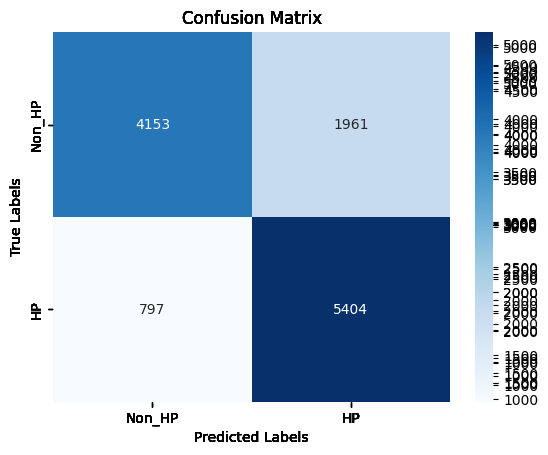

In [33]:
for fold in range(0, CONFIG['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    run = wandb.init(project='HP_results_Jira_High_vs_rest_results', 
                     config=CONFIG,
                     job_type='Train',
                     group=CONFIG['group'],
                     tags=[CONFIG['model_name'], f'{HASH_NAME}'],
                     name=f'{HASH_NAME}-fold-{fold}',
                     anonymous='must')
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(fold=fold)
    
    model = HP_Model(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'])
    scheduler = fetch_scheduler(optimizer)
    
    model, history = run_training(model, optimizer, scheduler,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    run.finish()
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()

<h2> Testing Inference </h2>


In [34]:
import warnings,transformers,logging,torch

warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

In [35]:
test_df = fine_tune_test_df

In [36]:
test_df

,text,label
483,unknownexception integration test flutter driv...,0
2004,review request for revert pr pull request was ...,1
277,regression in newgallerycraneperf see looks li...,1
1552,split out fml into its own independent library...,0
221,displaylist dispatching takes of frame time on...,1
...,...,...
1638,some rollers are not triggering all the builde...,1
1095,macios platformchannelsbenchmarksios failed to...,1
1130,review request for revert pr pull request was ...,1
1294,mac is flaky metatags to be used by the automa...,1


In [37]:
class HP_TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df['text'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                        text,
                        truncation=True,
                        add_special_tokens=True,
                        max_length=self.max_len
                    )
        
        samples = {
            'input_ids': inputs['input_ids'],
            'attention_mask': inputs['attention_mask'],
            
        }

        if 'token_type_ids' in inputs:
            samples['token_type_ids'] = inputs['token_type_ids']
        
        return samples

In [38]:
collate_fn = DataCollatorWithPadding(tokenizer=CONFIG['tokenizer'])

softmax = nn.Softmax(dim=1)
model = HP_Model(CONFIG['model_name'])

In [39]:
def prepare_test_loader(test_df):    
    test_dataset = HP_TestDataset(test_df, 
                                   tokenizer=CONFIG['tokenizer'], 
                                   max_length=CONFIG['max_length'])
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=CONFIG['valid_batch_size'], 
                             collate_fn=collate_fn, 
                             num_workers=2, 
                             shuffle=False, 
                             pin_memory=True, 
                             drop_last=False)
    return test_loader

test_loader = prepare_test_loader(test_df)

In [40]:
@torch.no_grad()
def inference(test_loader, model, device):
    preds = []
    preds_target = []
    model.eval()
    model.to(device)
    
    bar = tqdm(enumerate(test_loader), total=len(test_loader))
    
    for step, data in bar: 
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        
        output = model(ids, mask)
        y_preds = softmax(torch.tensor(output.to('cpu'))).numpy()
        pred_target = torch.argmax(output, dim=-1).flatten().tolist()
        
        preds.append(y_preds)
        preds_target.append(pred_target) 
    predictions = np.concatenate(preds)
    predictions_label = np.concatenate(preds_target)
    return predictions , predictions_label

In [41]:
# Change the HASH_NAME according to new generated hash for your run
#HASH_NAME = "ekgx4wmexn91"


In [42]:
deberta_predictions = []
deberta_predictions_labels = []



for fold in range(0, CONFIG['n_fold']):
    print("Fold {}".format(fold))
    
    state = torch.load(f'{HASH_NAME}-Loss-Fold-{fold}.bin')
    model.load_state_dict(state)
    
    prediction, predictions_label = inference(test_loader, model, CONFIG['device'])
    deberta_predictions.append(prediction)
    deberta_predictions_labels.append(predictions_label)
    del state, prediction; gc.collect()
    torch.cuda.empty_cache()
del model

Fold 0


100%|██████████| 104/104 [00:17<00:00,  5.94it/s]


Fold 1


100%|██████████| 104/104 [00:17<00:00,  5.95it/s]


Fold 2


100%|██████████| 104/104 [00:17<00:00,  5.94it/s]


In [43]:
deberta_predictions


[array([[0.7113114 , 0.28868854],
        [0.01940342, 0.9805966 ],
        [0.2714021 , 0.72859794],
        ...,
        [0.01940342, 0.9805966 ],
        [0.00955452, 0.9904455 ],
        [0.75069094, 0.24930905]], dtype=float32),
 array([[0.7235431 , 0.27645692],
        [0.07141449, 0.9285856 ],
        [0.33925956, 0.66074044],
        ...,
        [0.07141449, 0.9285856 ],
        [0.0205774 , 0.9794226 ],
        [0.87341195, 0.12658812]], dtype=float32),
 array([[0.68672603, 0.31327397],
        [0.07204609, 0.92795396],
        [0.28700414, 0.71299577],
        ...,
        [0.07204609, 0.92795396],
        [0.03194416, 0.9680558 ],
        [0.7589378 , 0.24106224]], dtype=float32)]

In [44]:
predictions = np.mean(deberta_predictions, axis=0)
predictions

array([[0.70719355, 0.29280648],
       [0.054288  , 0.9457121 ],
       [0.2992219 , 0.700778  ],
       ...,
       [0.054288  , 0.9457121 ],
       [0.02069203, 0.97930795],
       [0.79434687, 0.20565313]], dtype=float32)

In [45]:
len(predictions)

1659

In [46]:
predictions

array([[0.70719355, 0.29280648],
       [0.054288  , 0.9457121 ],
       [0.2992219 , 0.700778  ],
       ...,
       [0.054288  , 0.9457121 ],
       [0.02069203, 0.97930795],
       [0.79434687, 0.20565313]], dtype=float32)

In [47]:
test_df["prediction_0"] = predictions[:, 0] 

In [48]:
test_df["prediction_1"] = predictions[:, 1] 

In [49]:
for i in range(0, CONFIG['n_fold']):

    test_df[f"prediction_label_fold_{i}"] = deberta_predictions_labels[i]


In [50]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2
483,unknownexception integration test flutter driv...,0,0.707194,0.292806,0,0,0
2004,review request for revert pr pull request was ...,1,0.054288,0.945712,1,1,1
277,regression in newgallerycraneperf see looks li...,1,0.299222,0.700778,1,1,1
1552,split out fml into its own independent library...,0,0.655165,0.344835,0,0,0
221,displaylist dispatching takes of frame time on...,1,0.695431,0.304569,0,0,0
...,...,...,...,...,...,...,...
1638,some rollers are not triggering all the builde...,1,0.312010,0.687990,1,1,1
1095,macios platformchannelsbenchmarksios failed to...,1,0.035694,0.964307,1,1,1
1130,review request for revert pr pull request was ...,1,0.054288,0.945712,1,1,1
1294,mac is flaky metatags to be used by the automa...,1,0.020692,0.979308,1,1,1


In [51]:
len(test_df)

1659

In [52]:
test_df['Max'] = test_df[['prediction_0','prediction_1']].idxmax(axis=1)

In [53]:
test_df["pred"] = test_df['Max'].apply(lambda x: x.replace("prediction_0", "0"))

In [54]:
test_df["pred"] = test_df['pred'].apply(lambda x: x.replace("prediction_1", "1"))


In [55]:
test_df["pred"] = test_df["pred"].astype(int)

In [56]:
test_df

,text,label,prediction_0,prediction_1,prediction_label_fold_0,prediction_label_fold_1,prediction_label_fold_2,Max,pred
483,unknownexception integration test flutter driv...,0,0.707194,0.292806,0,0,0,prediction_0,0
2004,review request for revert pr pull request was ...,1,0.054288,0.945712,1,1,1,prediction_1,1
277,regression in newgallerycraneperf see looks li...,1,0.299222,0.700778,1,1,1,prediction_1,1
1552,split out fml into its own independent library...,0,0.655165,0.344835,0,0,0,prediction_0,0
221,displaylist dispatching takes of frame time on...,1,0.695431,0.304569,0,0,0,prediction_0,0
...,...,...,...,...,...,...,...,...,...
1638,some rollers are not triggering all the builde...,1,0.312010,0.687990,1,1,1,prediction_1,1
1095,macios platformchannelsbenchmarksios failed to...,1,0.035694,0.964307,1,1,1,prediction_1,1
1130,review request for revert pr pull request was ...,1,0.054288,0.945712,1,1,1,prediction_1,1
1294,mac is flaky metatags to be used by the automa...,1,0.020692,0.979308,1,1,1,prediction_1,1


In [57]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_df["label"].values, test_df["pred"].values)

print(cf_matrix)

[[518 298]
 [161 682]]


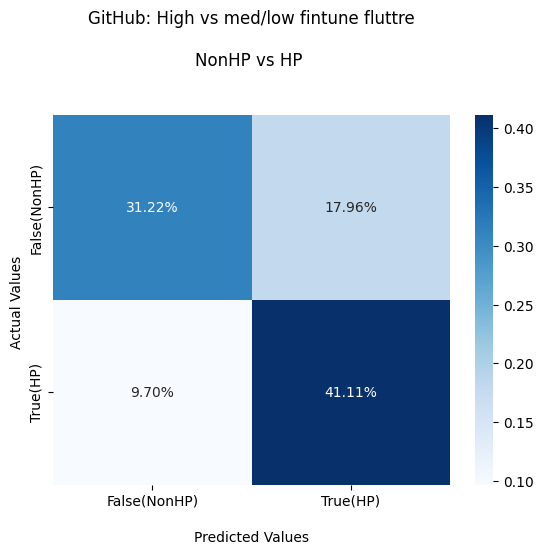

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('GitHub: High vs med/low fintune fluttre\n\nNonHP vs HP \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False(NonHP)','True(HP)'])
ax.yaxis.set_ticklabels(['False(NonHP)','True(HP)'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [59]:
from sklearn.metrics import classification_report


print(classification_report(test_df["label"].values, test_df["pred"].values))

              precision    recall  f1-score   support

           0       0.76      0.63      0.69       816
           1       0.70      0.81      0.75       843

    accuracy                           0.72      1659
   macro avg       0.73      0.72      0.72      1659
weighted avg       0.73      0.72      0.72      1659



In [60]:
test_df[["text","label","pred"]].to_csv("MongoDB_70_Test_inference.csv")

In [61]:
tracker.stop()

0.023754608898779155